# 시계열 예측 전처리 + 모델링

### data import

In [1]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import models, layers
import seaborn as sns

filename = 'shampoo-three-year.csv'

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv(filename)

In [3]:
dataset = dataset.dropna()

In [4]:
dataset.shape

(36, 2)

### data preview

In [5]:
dataset.head(40)

,Month,Sales of shampoo over a three year period
0,1901-01-01,266.0
1,1901-02-01,145.9
2,1901-03-01,183.1
3,1901-04-01,119.3
4,1901-05-01,180.3
5,1901-06-01,168.5
6,1901-07-01,231.8
7,1901-08-01,224.5
8,1901-09-01,192.8
9,1901-10-01,122.9


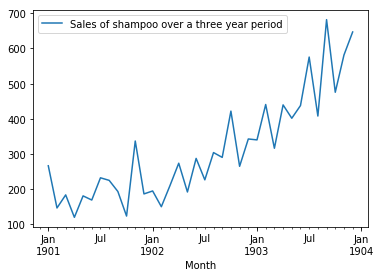

In [6]:
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.index = dataset['Month']
dataset.set_index('Month', inplace=True)
dataset.plot()
plt.show()

## data preprocessing

#### make n-step to n-step forecast dataset

In [7]:
dataset.values

array([[266. ],
       [145.9],
       [183.1],
       [119.3],
       [180.3],
       [168.5],
       [231.8],
       [224.5],
       [192.8],
       [122.9],
       [336.5],
       [185.9],
       [194.3],
       [149.5],
       [210.1],
       [273.3],
       [191.4],
       [287. ],
       [226. ],
       [303.6],
       [289.9],
       [421.6],
       [264.5],
       [342.3],
       [339.7],
       [440.4],
       [315.9],
       [439.3],
       [401.3],
       [437.4],
       [575.5],
       [407.6],
       [682. ],
       [475.3],
       [581.3],
       [646.9]])

In [8]:
"""
x_step : n-lag (몇 개를 가지고 예측할지)
y_step : n-seq (몇 개를 예측할지)
"""
def make_timeseries_dataset_random_ordered(series, x_steps=1, y_steps=1, test_size=0.2):
    def split_dataset(timeseries_data):
        x_data = timeseries_data[:, :x_steps]
        y_data = timeseries_data[:, x_steps:]
        return train_test_split(x_data, y_data, test_size=test_size)
    
    result = None
    for i in range(len(series)):
        # next step index limit
        if i <= len(series) - x_steps - y_steps:
            row = np.array([])
            # make 1 row by defined timeseries steps
            for step in range(x_steps + y_steps):
                row = np.concatenate((row, series[i+step]))
            # append row to result np array
            if result is None:
                result = row
            else:
                result = np.vstack((result, row))
    return split_dataset(result)
        

In [9]:
x_train, x_test, y_train, y_test = make_timeseries_dataset_random_ordered(series=dataset.values, x_steps=3, y_steps=1, test_size=0.2)

In [10]:
print('training X data shape:', x_train.shape)
print('training Y data shape:', y_train.shape)
print('test X data shape:', x_test.shape)
print('test Y data shape:', y_test.shape)

training X data shape: (26, 3)
training Y data shape: (26, 1)
test X data shape: (7, 3)
test Y data shape: (7, 1)


# Modeling 1. Prophet

In [11]:
!pip install pystan fbprophet

Prophet follows the sklearn model API. 
We create an instance of the Prophet class and then call its fit and predict methods.

In [12]:
from fbprophet import Prophet

### banila prediction (monthly)

In [13]:
dataset = pd.read_csv(filename)
dataset.columns = ['ds', 'y']
dataset.head()

,ds,y
0,1901-01-01,266.0
1,1901-02-01,145.9
2,1901-03-01,183.1
3,1901-04-01,119.3
4,1901-05-01,180.3


In [14]:
# month data fit : mode parameter setting
m = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(dataset)

/anaconda/envs/yoon/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [15]:
future_data = m.make_future_dataframe(periods=1, freq = 'm')

In [16]:
forecast_data = m.predict(future_data)

In [17]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
32,1903-09-01,582.655416,499.923232,661.703875
33,1903-10-01,492.576450,414.471666,579.258371
34,1903-11-01,541.283421,456.933046,621.263005
35,1903-12-01,569.945871,492.375554,653.112325
36,1903-12-31,500.410216,420.083220,579.224432


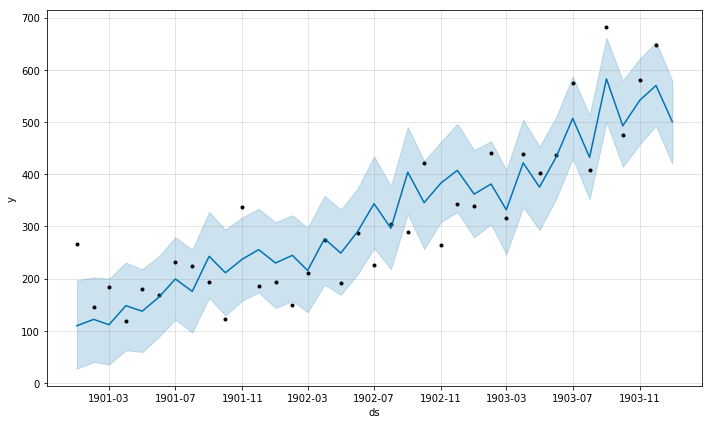

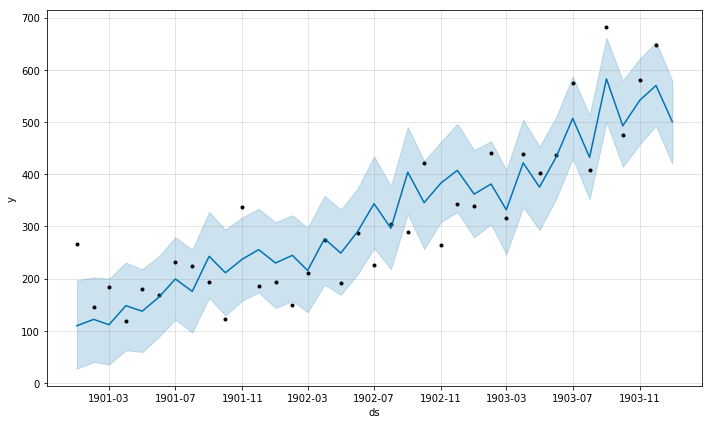

In [18]:
m.plot(forecast_data)

In [19]:
forecast_data.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1901-01-01,115.953396,27.192400,196.706663,115.953396,115.953396,-0.055206,-0.055206,-0.055206,-0.055206,-0.055206,-0.055206,0.0,0.0,0.0,109.552027
1,1901-02-01,126.766058,40.069995,202.404277,126.766058,126.766058,-0.039653,-0.039653,-0.039653,-0.039653,-0.039653,-0.039653,0.0,0.0,0.0,121.739463
2,1901-03-01,136.532332,35.268176,199.685881,136.532332,136.532332,-0.183439,-0.183439,-0.183439,-0.183439,-0.183439,-0.183439,0.0,0.0,0.0,111.486913
3,1901-04-01,147.344993,62.566427,230.494960,147.344993,147.344993,0.004130,0.004130,0.004130,0.004130,0.004130,0.004130,0.0,0.0,0.0,147.953455
4,1901-05-01,157.808859,59.242539,217.647111,157.808859,157.808859,-0.129300,-0.129300,-0.129300,-0.129300,-0.129300,-0.129300,0.0,0.0,0.0,137.404150


### apply saturating forecasting

- logistic growth 형태(상한과 하한이 있는 모형)로 예측 모델을 만들어 주는것.
- 일반적인 시계열 예측 모델은 saturating point가 있기 때문.

In [20]:
df_saturating = dataset
df_saturating['cap'] = 400
df_saturating['floor'] = 300

# month data fit : mode parameter setting
m = Prophet(growth='logistic', seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(df_saturating)

/anaconda/envs/yoon/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [21]:
future_data = m.make_future_dataframe(periods=1, freq = 'm')
future_data['cap'] = 400
future_data['floor'] = 300
forecast_data = m.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
32,1903-09-01,420.497187,267.427410,565.100615
33,1903-10-01,396.816812,245.591415,556.959824
34,1903-11-01,400.333321,252.600954,552.459844
35,1903-12-01,422.099080,277.688513,572.727857
36,1903-12-31,380.605378,234.677399,540.296156


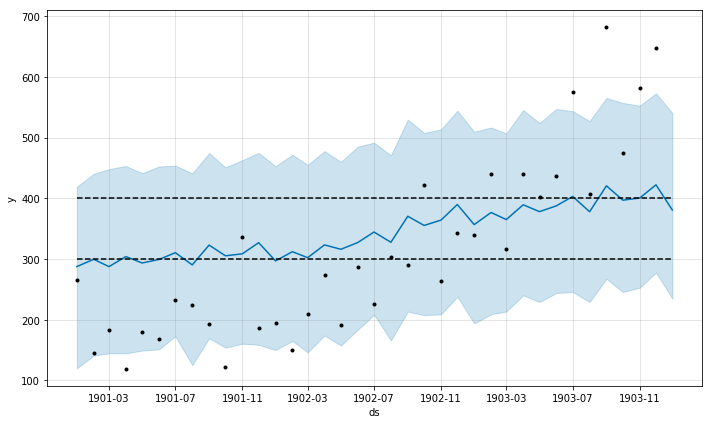

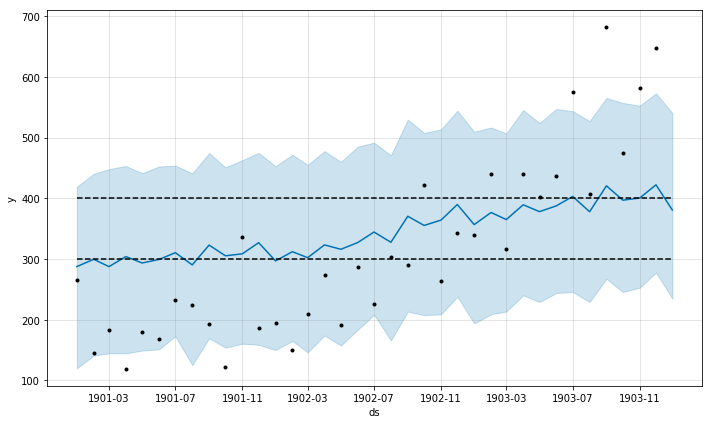

In [22]:
m.plot(forecast_data)

### outlier가 포함된 시계열 예측

In [23]:
dataset.loc[dataset['ds'] == '1902-07-01', 'y'] = 850
dataset.loc[dataset['ds'] == '1902-12-01', 'y'] = 10

In [24]:
# month data fit : mode parameter setting
m = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(dataset)

/anaconda/envs/yoon/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [25]:
future_data = m.make_future_dataframe(periods=1, freq = 'm')
forecast_data = m.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
32,1903-09-01,548.662520,418.069312,684.273788
33,1903-10-01,469.502223,334.953712,606.981321
34,1903-11-01,523.148055,372.814030,659.299085
35,1903-12-01,415.565774,266.893666,547.167444
36,1903-12-31,502.168400,363.427474,634.390955


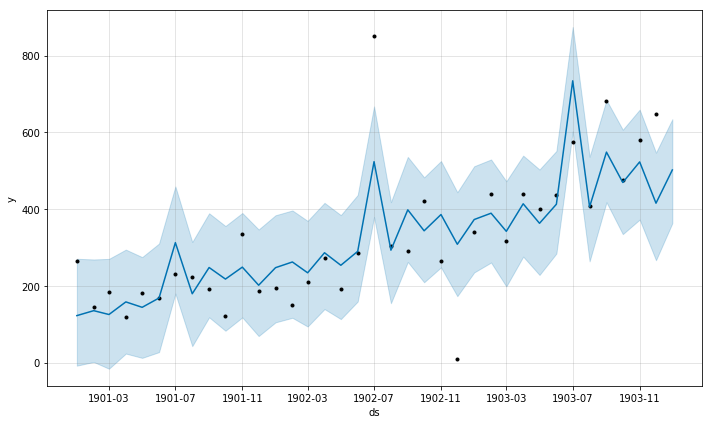

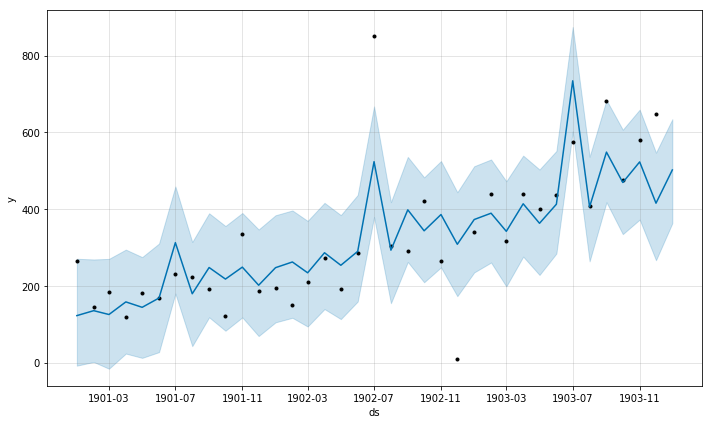

In [26]:
m.plot(forecast_data)

### rm outlier

In [27]:
dataset.loc[dataset['ds'] == '1902-07-01', 'y'] = None
dataset.loc[dataset['ds'] == '1902-12-01', 'y'] = None

In [28]:
# month data fit : mode parameter setting
m = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(dataset)

/anaconda/envs/yoon/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [29]:
future_data = m.make_future_dataframe(periods=1, freq = 'm')
forecast_data = m.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
32,1903-09-01,576.676154,504.405790,653.985832
33,1903-10-01,487.959930,413.672562,567.475050
34,1903-11-01,535.186213,458.717853,616.121523
35,1903-12-01,603.438624,524.513346,681.000809
36,1903-12-31,484.911190,405.708774,562.910345


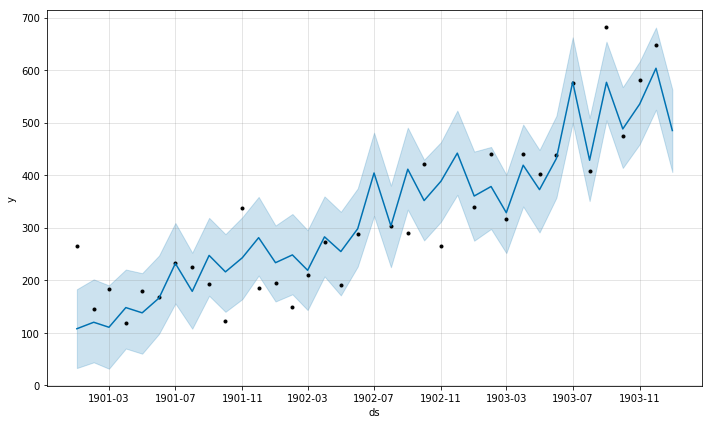

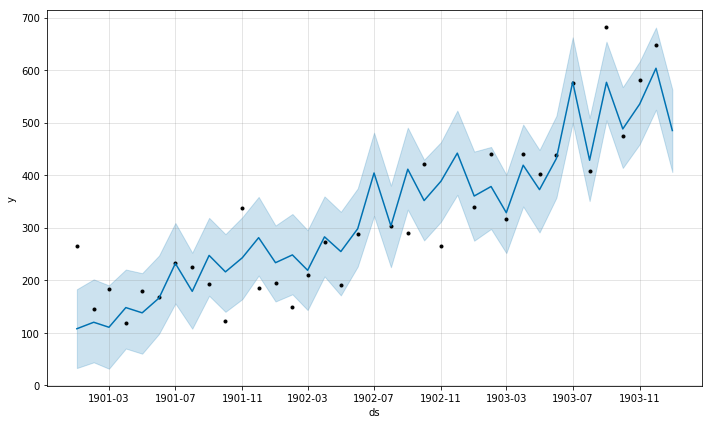

In [30]:
m.plot(forecast_data)

## Modeling 2. ARIMA(Autoregressive Integrated Moving Average)

- ARIMA는 Autoregressive Integrated Moving Average의 약자로, Autoregressive는 자기회귀 모형을 의미하고, Moving Average는 이동평균 모형을 의미한다.
- AR(Autoregression), 자기회귀 모형 : 이전의 자신의 관측값이 이후의 자신의 관측값에 영향을 준다는 아이디어의 모형이다. 큰 틀에서의 의미는 RNN과 완전히 동일하다. 다만, 선형적인 관계만을 정의하므로 정확하지는 않다.
- AR의 수식 : AR(1) -> Xt = theta * Xt-1 + et

- MA(Moving Average), 이동평균 모형 : 현재의 관측값이 이전의 관측 오차항에 영향을 받는다는 아이디어의 모형이다. 
- MA(1) -> Xt = et - B1 * et-1

- 이를 합한 ARMA 모형은 다음과 같다. 
- Xt=ϕXt−1+Wt+θWt−1
- 즉 정상성이 보장된다는 조건 하에 p차까지 자기회귀를 하고, 남은 잔차의 상관관계를 이용하여 오차항을 만들어내는 모형이다.
- ARIMA에서 I는 Integrated를 의미하는데, ARMA에서 시계열의 비정상성을 설명하기 위해 차분방정식의 개념을 도입하여 보정한 것을 의미하는 용어이다.

--------

- ARIMA의 하이퍼 파라미터는 3가지이다.
- (p, d , q)의 세 가지로, p와 q는 각각 AR, MA의 lag 개수를 의미하며 d는 차분의 횟수를 의미한다.

<img src="images/ARIMA.png">

### hyper parameter를 선정하는 방법
- ACF(Autocorrelation function) : Lag에 따른 관측치들 사이의 관련성을 측정하는 함수
- PACF(Partial autocorrelation function) : k 이외의 모든 다른 시점 관측치의 영향력을 배제하고 yt와 yt-k 두 관측치의 관련성을 측정하는 함수
- 두 그래프 중, 감소폭이나 증가폭이 완만한 그래프가 더 강한 영향을 미치는 것이라고 볼 수 있다.

- 시계열 데이터가 AR의 특성을 띄는 경우, ACF는 천천히 감소하고 PACF는 처음 시차를 제외하고 급격히 감소한다.
- 반대로, MA의 특성을 띄는 경우 ACF는 급격히 감소하고 PACF는 천천히 감소한다.
- 급격히 감소하는 시차를 각 AR과 MA 모형의 모수(p, q)로 사용할 수 있다. 
- 또한 데이터를 차분하여 ACF 및 PACF 계산함으로써 적절한 차분횟수까지 구할 수 있다

In [31]:
dataset = pd.read_csv(filename)
dataset.columns = ['Month', 'sale']
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.index = dataset['Month']
dataset.set_index('Month', inplace=True)
series = dataset

/anaconda/envs/yoon/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


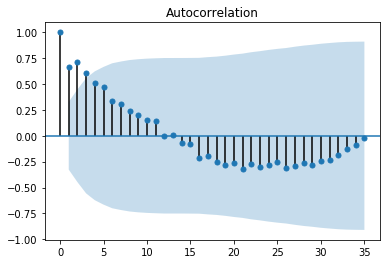

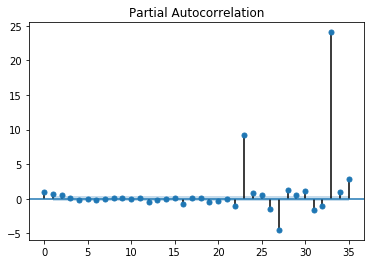

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(series)
plot_pacf(series)
plt.show()

#### ARIMA 모델링

In [33]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(4,1,0)) # P>|z| -> 학습 계수에 대한 p-value 값으로, (a,b,c) 일때 가장 적절한 조합을 찾아야 한다.
model_fit = model.fit(trend='c',full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.sale   No. Observations:                   35
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -196.393
Method:                       css-mle   S.D. of innovations             64.746
Date:                Wed, 29 Aug 2018   AIC                            404.787
Time:                        01:00:31   BIC                            414.119
Sample:                    02-01-1901   HQIC                           408.008
                         - 12-01-1903                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           12.1963      3.217      3.791      0.001       5.891      18.502
ar.L1.D.sale    -1.1456      0.176     -6.504      0.000      -1.491      -0.800
ar.L2.D.sale    -0.6921      0.264     -2.62

/anaconda/envs/yoon/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda/envs/yoon/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda/envs/yoon/lib/python3.6/site-packages/scipy/signal/signaltools.py:1333: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda/envs/yoon/lib/python3.6/site-packages/scipy/signal/signaltools.py:1336: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In t

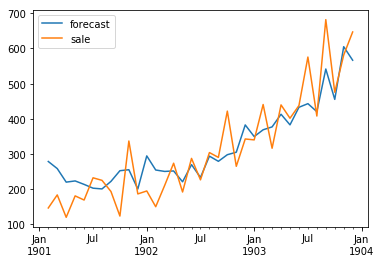

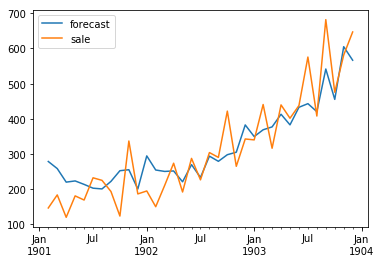

In [34]:
model_fit.plot_predict()

In [35]:
fore = model_fit.forecast(steps=3)
print(fore[0]) # 예측값

[562.5949253  664.01590921 591.62434483]


## Modeling 3. LSTM
### 3-1) multi-to-one step

In [36]:
import os
import math
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#### preprocessing for time-step forecasting

In [37]:
dataset = pd.read_csv(filename)
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.index = dataset['Month']
dataset.set_index('Month', inplace=True)
origin_series = dataset.values

"""
시계열 예측시에는 t, t-1 의 차이값을 value로 활용
"""
def difference(series, interval=1):
    diff = list()
    for i in range(interval, len(series)):
        value = series[i] - series[i - interval]
        diff.append(value)
    return np.array(diff)

"""
x_step : n-lag (몇 개를 가지고 예측할지)
y_step : n-seq (몇 개를 예측할지)
"""
def make_timeseries_dataset_ordered(series, x_steps=1, y_steps=1, test_size=0.2):
    def split_dataset(timeseries_data):
        x_data = timeseries_data[:, :x_steps]
        y_data = timeseries_data[:, x_steps:]
        train_len = int(x_data.shape[0] * (1 - test_size))
        x_train = x_data[:train_len, :]
        x_test = x_data[train_len:, :]
        y_train =  y_data[:train_len, :]
        y_test = y_data[train_len:, :]
        return (x_train, x_test, y_train, y_test)
    
    result = None
    for i in range(len(series)):
        # next step index limit
        if i <= len(series) - x_steps - y_steps:
            row = np.array([])
            # make 1 row by defined timeseries steps
            for step in range(x_steps + y_steps):
                row = np.concatenate((row, series[i+step]))
            # append row to result np array
            if result is None:
                result = row
            else:
                result = np.vstack((result, row))
    return split_dataset(result)

"""
split origin dataset
"""
# def split_dataset():
    

# split origin dataset
origin_x_train, origin_x_test, origin_y_train, origin_y_test = make_timeseries_dataset_ordered(series=origin_series, x_steps=1, y_steps=1, test_size=0.4)
# transform original value to diff value
diff_series = difference(origin_series, 1)
# min-max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(diff_series)
# split and make timeseries
x_train, x_test, y_train, y_test = make_timeseries_dataset_ordered(series=scaled_series, x_steps=4, y_steps=1, test_size=0.4)

- print shape

In [38]:
print('training X data shape:', origin_x_train.shape)
print('training Y data shape:', origin_y_train.shape)
print('test X data shape:', origin_x_test.shape)
print('test Y data shape:', origin_y_test.shape)

training X data shape: (21, 1)
training Y data shape: (21, 1)
test X data shape: (14, 1)
test Y data shape: (14, 1)


In [39]:
print('training X data shape:', x_train.shape)
print('training Y data shape:', y_train.shape)
print('test X data shape:', x_test.shape)
print('test Y data shape:', y_test.shape)

training X data shape: (18, 4)
training Y data shape: (18, 1)
test X data shape: (13, 4)
test Y data shape: (13, 1)


In [40]:
# data reshape : for trim batch size (train, predict in Neural Networks)
x_train = x_train[:16, :]
y_train = y_train[:16, :]
x_test = x_test[:12, :]
y_test = y_test[:12, :]

In [41]:
print('training X data shape:', x_train.shape)
print('training Y data shape:', y_train.shape)
print('test X data shape:', x_test.shape)
print('test Y data shape:', y_test.shape)

training X data shape: (16, 4)
training Y data shape: (16, 1)
test X data shape: (12, 4)
test Y data shape: (12, 1)


- change shape for (LSTM or RNN)

In [42]:
"""
(size, timestep, feature) 의 형식으로 맞춰줘야 함
size : batch를 돌 데이터 사이즈
timestep : input의 time 개수 (X_t1, X_t2...)
feature : feature의 개수 (X = x1, x2 ...) [ex: x1 - 키, x2 - 몸무게 ...]
"""

time_step = 4
feature_num = 1

x_train_series = x_train.reshape(x_train.shape[0], time_step, feature_num)
x_test_series = x_test.reshape(x_test.shape[0], time_step, feature_num)

#### LSTM modeling code

In [43]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

/anaconda/envs/yoon/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/anaconda/envs/yoon/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


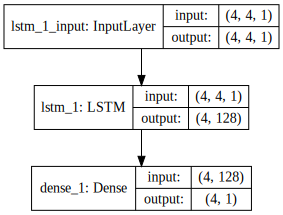

In [44]:
model = Sequential()
model.add(LSTM(128, batch_input_shape=(4, 4, 1), # batch_input_shape = (배치사이즈, 타임스텝, 속성)
               return_sequences=False, 
               stateful=True))
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam')

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

- return_sequences : many-to-many 문제나 lstm가 멀티 레이어인 경우 사용함. 각 time마다 y값을 출력 하느냐 마느냐의 결정.
- stateful : 상태유지모드 결정. 

#### stateful True

In [45]:
num_epochs = 500
batch_size=4

# simple lstm network learning
model = Sequential()
model.add(LSTM(3, batch_input_shape=(batch_size, time_step, feature_num), # batch_input_shape = (배치사이즈, 타임스텝, 속성)
               return_sequences=False, 
               stateful=True))
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam')

for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(x_train_series, y_train, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

/anaconda/envs/yoon/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/anaconda/envs/yoon/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


epochs : 0
Epoch 1/1
16/16 [==============================] - 0s 26ms/step - loss: 0.1024
epochs : 1
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0933
epochs : 2
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0851
epochs : 3
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0778
epochs : 4
Epoch 1/1
16/16 [==============================] - 0s 2ms/step - loss: 0.0713
epochs : 5
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0656
epochs : 6
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0607
epochs : 7
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0564
epochs : 8
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0527
epochs : 9
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0496
epochs : 10
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0470
epochs : 11
Epoch 1

16/16 [==============================] - 0s 994us/step - loss: 0.0315
epochs : 92
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0314
epochs : 93
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0313
epochs : 94
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0313
epochs : 95
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0312
epochs : 96
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0311
epochs : 97
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0311
epochs : 98
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0310
epochs : 99
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0310
epochs : 100
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0309
epochs : 101
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0308
epochs : 102
Epoch 1/1
16/16

16/16 [==============================] - 0s 1ms/step - loss: 0.0263
epochs : 182
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0263
epochs : 183
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0262
epochs : 184
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0262
epochs : 185
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0261
epochs : 186
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0261
epochs : 187
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0260
epochs : 188
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0260
epochs : 189
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0259
epochs : 190
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0259
epochs : 191
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0258
epochs : 192
Epoch 1/1

16/16 [==============================] - 0s 1ms/step - loss: 0.0220
epochs : 272
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0219
epochs : 273
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0219
epochs : 274
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0218
epochs : 275
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0218
epochs : 276
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0217
epochs : 277
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0217
epochs : 278
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0217
epochs : 279
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0216
epochs : 280
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0216
epochs : 281
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0215
epochs : 282
Epoch 1/1

16/16 [==============================] - 0s 1ms/step - loss: 0.0189
epochs : 362
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0189
epochs : 363
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0189
epochs : 364
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0189
epochs : 365
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0189
epochs : 366
Epoch 1/1
16/16 [==============================] - 0s 2ms/step - loss: 0.0188
epochs : 367
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0188
epochs : 368
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0188
epochs : 369
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0188
epochs : 370
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0187
epochs : 371
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0187
epochs : 372
Epoch 1/1

16/16 [==============================] - 0s 1ms/step - loss: 0.0172
epochs : 452
Epoch 1/1
16/16 [==============================] - 0s 2ms/step - loss: 0.0172
epochs : 453
Epoch 1/1
16/16 [==============================] - 0s 2ms/step - loss: 0.0172
epochs : 454
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0172
epochs : 455
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0172
epochs : 456
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0172
epochs : 457
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0172
epochs : 458
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0171
epochs : 459
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0171
epochs : 460
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0171
epochs : 461
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0171
epochs : 462
Epoch 1/1

In [46]:
def show_train_fit():
    output = model.predict(x_train_series, batch_size=batch_size)
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        yhat = scaler.inverse_transform(yhat)
        yhat = yhat + origin_x_train[i+1]
        predictions.append(yhat)
    model.reset_states()
    return predictions

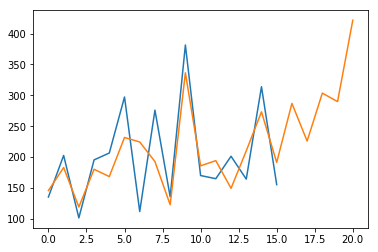

In [47]:
predictions = show_train_fit()
predictions = np.array(predictions)
predictions = predictions.reshape(predictions.shape[0], 1)

plt.plot(predictions) # blue line
plt.plot(origin_y_train) # yellow line
plt.show()

In [48]:
def show_test_fit():
    output = model.predict(x_test_series, batch_size=batch_size)
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        yhat = scaler.inverse_transform(yhat)
        yhat = yhat + origin_x_test[i+1]
        predictions.append(yhat)
    model.reset_states()
    return predictions

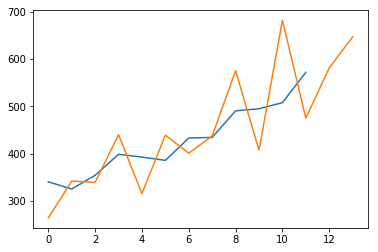

In [49]:
predictions = show_test_fit()
predictions = np.array(predictions)
predictions = predictions.reshape(predictions.shape[0], 1)

plt.plot(predictions) # blue line
plt.plot(origin_y_test) # yellow line
plt.show()

#### stateful False

In [50]:
num_epochs = 500
batch_size=4

# simple lstm network learning
model = Sequential()
model.add(LSTM(3, batch_input_shape=(batch_size, time_step, feature_num), # batch_input_shape = (배치사이즈, 타임스텝, 속성)
               return_sequences=False, 
               stateful=False))
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train_series, y_train, epochs=num_epochs, batch_size=batch_size, verbose=1, shuffle=False)

/anaconda/envs/yoon/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/anaconda/envs/yoon/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Epoch 1/500
16/16 [==============================] - 0s 27ms/step - loss: 0.2877
Epoch 2/500
16/16 [==============================] - 0s 1ms/step - loss: 0.2780
Epoch 3/500
16/16 [==============================] - 0s 1ms/step - loss: 0.2688
Epoch 4/500
16/16 [==============================] - 0s 1ms/step - loss: 0.2599
Epoch 5/500
16/16 [==============================] - 0s 1ms/step - loss: 0.2515
Epoch 6/500
16/16 [==============================] - 0s 1ms/step - loss: 0.2435
Epoch 7/500
16/16 [==============================] - 0s 2ms/step - loss: 0.2359
Epoch 8/500
16/16 [==============================] - 0s 982us/step - loss: 0.2286
Epoch 9/500
16/16 [==============================] - 0s 1ms/step - loss: 0.2217
Epoch 10/500
16/16 [==============================] - 0s 1ms/step - loss: 0.2151
Epoch 11/500
16/16 [==============================] - 0s 1ms/step - loss: 0.2088
Epoch 12/500
16/16 [==============================] - 0s 1ms/step - loss: 0.2028
Epoch 13/500
16/16 [==============

16/16 [==============================] - 0s 1ms/step - loss: 0.0312
Epoch 103/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0312
Epoch 104/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0312
Epoch 105/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0312
Epoch 106/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0311
Epoch 107/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0311
Epoch 108/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0311
Epoch 109/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0311
Epoch 110/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0311
Epoch 111/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0311
Epoch 112/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0310
Epoch 113/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0310
Epoch 114/500
16/16 [=========

16/16 [==============================] - 0s 2ms/step - loss: 0.0297
Epoch 203/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0297
Epoch 204/500
16/16 [==============================] - 0s 2ms/step - loss: 0.0296
Epoch 205/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0296
Epoch 206/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0296
Epoch 207/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0296
Epoch 208/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0296
Epoch 209/500
16/16 [==============================] - 0s 2ms/step - loss: 0.0296
Epoch 210/500
16/16 [==============================] - 0s 2ms/step - loss: 0.0295
Epoch 211/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0295
Epoch 212/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0295
Epoch 213/500
16/16 [==============================] - 0s 2ms/step - loss: 0.0295
Epoch 214/500
16/16 [=========

16/16 [==============================] - 0s 1ms/step - loss: 0.0279
Epoch 303/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0278
Epoch 304/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0278
Epoch 305/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0278
Epoch 306/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0278
Epoch 307/500
16/16 [==============================] - 0s 2ms/step - loss: 0.0278
Epoch 308/500
16/16 [==============================] - 0s 2ms/step - loss: 0.0277
Epoch 309/500
16/16 [==============================] - 0s 2ms/step - loss: 0.0277
Epoch 310/500
16/16 [==============================] - 0s 2ms/step - loss: 0.0277
Epoch 311/500
16/16 [==============================] - 0s 2ms/step - loss: 0.0277
Epoch 312/500
16/16 [==============================] - 0s 2ms/step - loss: 0.0277
Epoch 313/500
16/16 [==============================] - 0s 2ms/step - loss: 0.0276
Epoch 314/500
16/16 [=========

16/16 [==============================] - 0s 1ms/step - loss: 0.0254
Epoch 403/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0254
Epoch 404/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0254
Epoch 405/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0253
Epoch 406/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0253
Epoch 407/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0253
Epoch 408/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0252
Epoch 409/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0252
Epoch 410/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0252
Epoch 411/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0251
Epoch 412/500
16/16 [==============================] - 0s 2ms/step - loss: 0.0251
Epoch 413/500
16/16 [==============================] - 0s 2ms/step - loss: 0.0251
Epoch 414/500
16/16 [=========

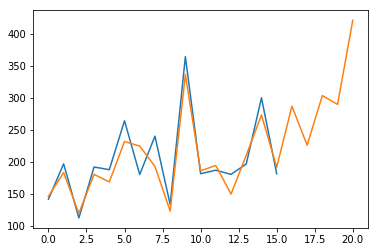

In [51]:
predictions = show_train_fit()
predictions = np.array(predictions)
predictions = predictions.reshape(predictions.shape[0], 1)

plt.plot(predictions) # blue line
plt.plot(origin_y_train) # yellow line
plt.show()

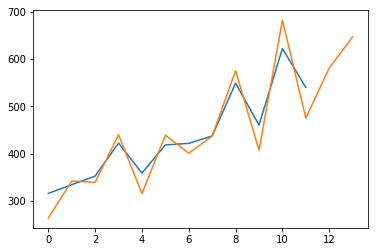

In [52]:
predictions = show_test_fit()
predictions = np.array(predictions)
predictions = predictions.reshape(predictions.shape[0], 1)

plt.plot(predictions) # blue line
plt.plot(origin_y_test) # yellow line
plt.show()